## Using scMKL with single-cell RNA Data
To run tutorials, install `plotnine` and `jupyter` into your scMKL env with `pip install plotnine jupyter`.
Here we will run scMKL on a subset of the MCF-7 data (1,000 cells x 36,601 genes) using Hallmark groupings.

### Importing Modules
Data is read-in and saved using Numpy and SciPy modules.

In [1]:
import scmkl

# Packages needed to import data
import numpy as np
from scipy.sparse import load_npz

# Modules for viewing results
import pandas as pd
from plotnine import *

### Reading in Data
There are four pieces of data (per modality) required for scMKL:
- The data matrix itself with cells as rows and features as columns.
    - Can be either a Numpy array or SciPy sparse array (scipy.sparse.csc_array is the recommended format).  
- The sample labels in a Numpy array. To perform group lasso, these labels must be binary.
- Feature names in a Numpy array. These are the names of the features corresponding with the data matrix columns.
- A dictionary with grouping data.  The keys are the names of the groups, and the values are the corresponding features.
    - Example: {Group1: [feature1, feature2, feature3], Group2: [feature4, feature5, feature6], ...}.
    - See `getting_RNA_groupings.ipynb` for more information on pulling gene sets.

In [2]:
# Reading in grouping dictionary from pickle file
group_dict = np.load('./data/_RNA_hallmark_groupings.pkl', allow_pickle = True)

# Reading in data to be analyzed
X = load_npz('./data/_MCF7_RNA_X.npz')
cell_labels = np.load('./data/_MCF7_cell_labels.npy', allow_pickle = True)
feature_names = np.load('./data/_MCF7_RNA_feature_names.npy', allow_pickle = True)

# D is the number of dimensions per group
# Previous literature shows the calculation below yields optimal number of dimensions
D = scmkl.calculate_d(len(cell_labels))

### Creating an AnnData Object
scMKL takes advantage of AnnData's flexible structure to create a straight-forward approach to running scMKL. Using `scmkl.create_adata()` will create an AnnData object from input data that will include necessary variables for running scMKL. For more information, see scMKL's [documentation](https://ohsu-cedar-comp-hub.github.io/scMKL/).

In [3]:
adata = scmkl.create_adata(X = X, 
                         feature_names = feature_names, 
                         cell_labels = cell_labels, 
                         group_dict = group_dict,
                         D = D
                         )

### Estimating Kernel Widths
`sigma` refers to kernel widths and should be estimated with `estimate_sigma()`.

In [14]:
adata = scmkl.estimate_sigma(adata, n_features = 200)#, batch_size= 50, batches = 10)

AssertionError: 1000 cells required for 10 batches of 100 cells; only 800 cells present

### Calculating Z
The Z matrices are a the Fourier transform of the grouped data matrix. This is calculated on training and testing samples separately. 

Returns Z matrices for training and testing in adata object with `adata.uns['Z_train']` and `adata.uns['Z_test']`.

In [5]:
adata = scmkl.calculate_z(adata, n_features = 5000)

### Optimizing Sparsity
Sparsity (lambda) or alpha here, is the regularization coefficient that controls the pentalty to run with the model. 

This will ultimately decide how many groups will be used in the final model.

`scmkl.optimize_alpha()` returns a single sparsity value as the optimal sparsity argument for training the model.

In [6]:
print(adata.uns['train_indices'])

[ 70 156 250 468  13 354  39  64 473 273 491 174  18 120 396 400 119 465
 262 210  90 208  11 266 195 287 108 424   2 116 247 394 133 486 498 305
 141 304 462 113 448 342 137 493 355 300 371 405 130 463 418 325 148 397
  94 105  42  65  62 197 182 178 295  19 358 436   6 274  69 402 233 484
 112 417  47 435  29 252 431  99  73 453 296 320 279 179 202  48 152 327
  97   0  82 345 268 157  91 289 495 307 159 164 391 481  61 425  15 362
 242 207 185  68 387 326 199 230 470 432 183 351 191  33 163 232  41 204
  81 161 200 353 329 253 257 389 190 322 226 377 466 330 332 450 357 461
 286 331 104 308 203 442  84 419 315 388 293 314 222 229 170 438 269 464
  74 333 100 225 173 228 378 437 343 292  85 337 282 347 127 290 235 324
 180  49 341 335 294 261  23 265 455 154 198 319 241 283  21 245 187 375
 194 147  12 393 217 415  32  67 140  51 151  36 249  46   8  45 124 499
 280 114 231 254 117 346 211 445 430 123 338 472  86  77 128 169 115 379
 142 364 206 256 285 454  50 193 246 237 277 452  6

In [7]:
# Setting a list of alpha values to train the model with
alpha_list = np.round(np.linspace(2.2,0.05,10), 2)

# Calculating the best performing alpha from cross validation on training data
alpha_star = scmkl.optimize_alpha(adata = adata, alpha_array = alpha_list, k = 4)

### Training and Evalutating Model
Here we will train and evaluate 10 models, each with a different `alpha`.

`alpha` (or lambda) is a regularization coefficient that deterimines how many groupings will be used to classify the test cells in the final model. Here, we will evalutate the model using a range of alphas (`alpha_list`) to get a range of selected groups.

In [8]:
results = scmkl.run(adata = adata, alpha_list = alpha_list)

  Evaluating model. Alpha: 2.2
  Evaluating model. Alpha: 1.96
  Evaluating model. Alpha: 1.72
  Evaluating model. Alpha: 1.48
  Evaluating model. Alpha: 1.24
  Evaluating model. Alpha: 1.01
  Evaluating model. Alpha: 0.77
  Evaluating model. Alpha: 0.53
  Evaluating model. Alpha: 0.29
  Evaluating model. Alpha: 0.05


### Model Performance and Top Groups per Alpha

In [9]:
summary_df = scmkl.get_summary(results)
summary_df

,Alpha,AUROC,Number of Selected Groups,Top Group
0,2.20,0.9274,2,HALLMARK_ESTROGEN_RESPONSE_LATE
1,1.96,0.9561,5,HALLMARK_ESTROGEN_RESPONSE_LATE
2,1.72,0.9718,8,HALLMARK_ESTROGEN_RESPONSE_LATE
3,1.48,0.9789,10,HALLMARK_ESTROGEN_RESPONSE_LATE
4,1.24,0.9829,11,HALLMARK_ESTROGEN_RESPONSE_LATE
5,1.01,0.9845,16,HALLMARK_ESTROGEN_RESPONSE_LATE
6,0.77,0.9865,20,HALLMARK_ESTROGEN_RESPONSE_LATE
7,0.53,0.9879,26,HALLMARK_ESTROGEN_RESPONSE_LATE
8,0.29,0.9874,37,HALLMARK_ESTROGEN_RESPONSE_LATE
9,0.05,0.9784,46,HALLMARK_ESTROGEN_RESPONSE_LATE


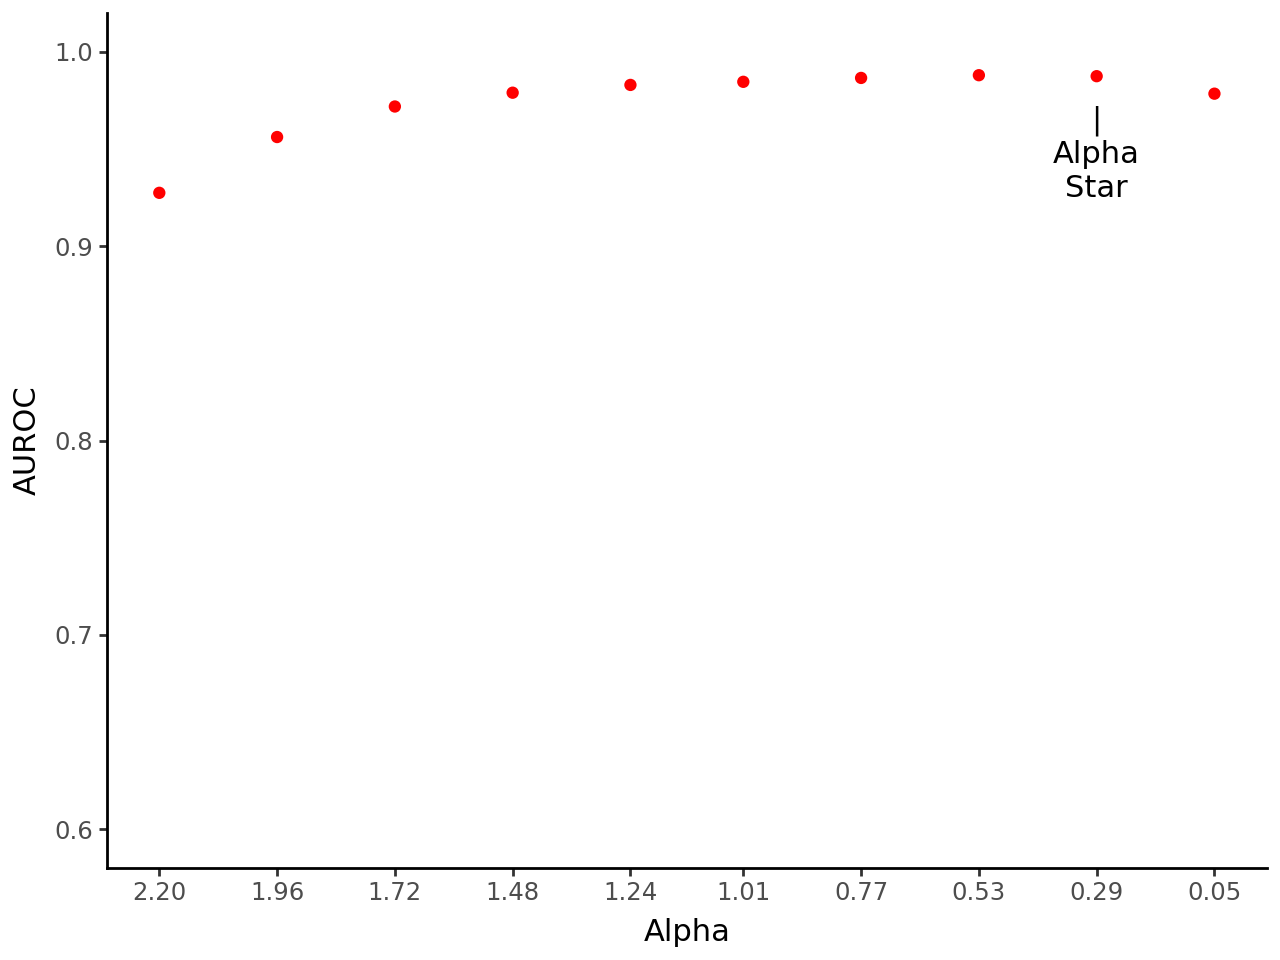

In [10]:
metric_plot = scmkl.plot_metric(summary_df, color = 'red', alpha_star = alpha_star)
metric_plot.show()

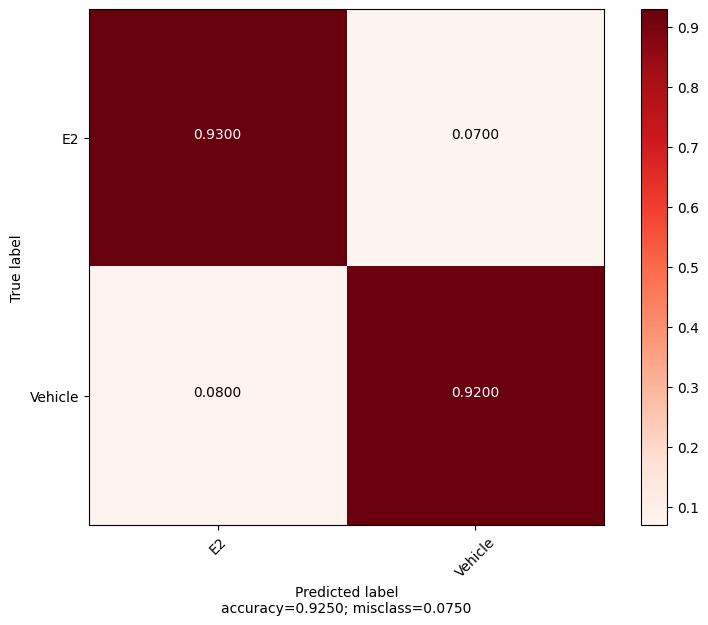

In [11]:
from matplotlib.pyplot import get_cmap

scmkl.plot_conf_mat(results, title = '', cmap = get_cmap('Reds'))